# Food image classification

Create a deep learning model to classify images using the Fast AI library and the Food-101 dataset.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
import glob
from io import BytesIO
import numpy as np

In [ ]:
bs = 64

In [ ]:
# wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# curl -o food101.tgz https://s3.amazonaws.com/fast-ai-imageclas/food-101.tgz
# tar -xvzf food101.tgz

In [4]:
path = Path('data/food-101/food-101')
path_img = path/'images'

In [ ]:
path.ls()

In [5]:
train_path = 'data/food-101/food-101/train.txt'
test_path = 'data/food-101/food-101/test.txt'

In [6]:
def file2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

In [7]:
train_df = file2df(train_path)
test_df = file2df(test_path)

In [8]:
train_df.head()

,label,name
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [9]:
np.random.seed(2)

## Dataset

The Food-101 dataset has 101 food categories, with 1000 images provided for each category for a total of 101,000 images. The Food-101 dataset provides a list of examples for training as well as another list for testing. Since the dataset specifies an equal amount of examples for each category, we do not need to worry about class imbalances. For each category, 250 images are in the test set and 750 for the training set. The training set is split into 20% for the validation set and 80% for the training set.

- Training set: 60600 images
- Validation set: 15150 images
- Test set: 25250 images

The images are resized to 224x224 for faster training of the model.

## Training: Resnet50-224

- Use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. 

In [ ]:
# The initial batch size used is 64 for 224x224 images. 
# ResNet-50 model is used as a starting point for the transfer learning process.

data = (ImageItemList.from_df(df=train_df, path=path_img, cols=1)
        .random_split_by_pct(0.2)
        .label_from_df(cols=0)
        .transform(tfms=get_transforms(), size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(10,10))

In [ ]:
print(data.classes)
len(data.classes),data.c, len(data.train_ds), len(data.valid_ds)

In [10]:
top_5 = partial(top_k_accuracy, k=5)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, top_5])

In [ ]:
learn.model

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2) # Default learning rate is 3e-3

In [ ]:
learn.save('resnet50-stage1-1')

## Unfreezing, fine-tuning, and learning rates

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('resnet50-stage1-2')

In [ ]:
learn.load('resnet50-stage1-2');

In [ ]:
# learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4)) 

In [ ]:
# learn.save('resnet50-stage1-3') 

## Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
losses,idxs = interp.top_losses()

In [ ]:
len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

## Training: resnet50-512

Faster approach to SoTA performance - start by training the network with an image size of 224, once the loss started to converge, train the network again with an image size of 512.

In [11]:
data = (ImageList.from_df(df=train_df, path=path_img, cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(tfms=get_transforms(), size=512)
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, top_5])

In [ ]:
learn.load('resnet50-stage1-2');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-2))

In [ ]:
learn.save('resnet50-stage2-1')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('resnet50-stage2-2')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('resnet50-stage2-3')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('resnet50-stage2-4')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-5,4e-4))

In [ ]:
learn.save('resnet50-stage2-5')

In [44]:
learn.load('resnet50-stage2-5')

Learner(data=ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/food-101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
fish_and_chips,tuna_tartare,tuna_tartare,chicken_quesadilla,eggs_benedict
Path: data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [45]:
learn.unfreeze()

In [ ]:
learn.lr_find()

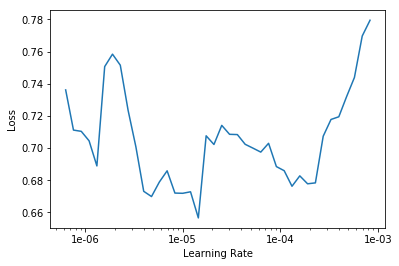

In [47]:
learn.recorder.plot(skip_end=15)

In [48]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.775885,0.697539,0.816964,0.949637,18:08
1,0.718332,0.693272,0.816304,0.949901,18:15
2,0.674008,0.679447,0.819208,0.951947,18:16
3,0.635283,0.674789,0.821980,0.952409,18:16
4,0.606976,0.667834,0.826799,0.952541,18:17
5,0.627114,0.664924,0.826865,0.953531,18:16


In [49]:
learn.save('resnet50-stage2-6')

In [ ]:
# learn.validate(learn.data.valid_dl)

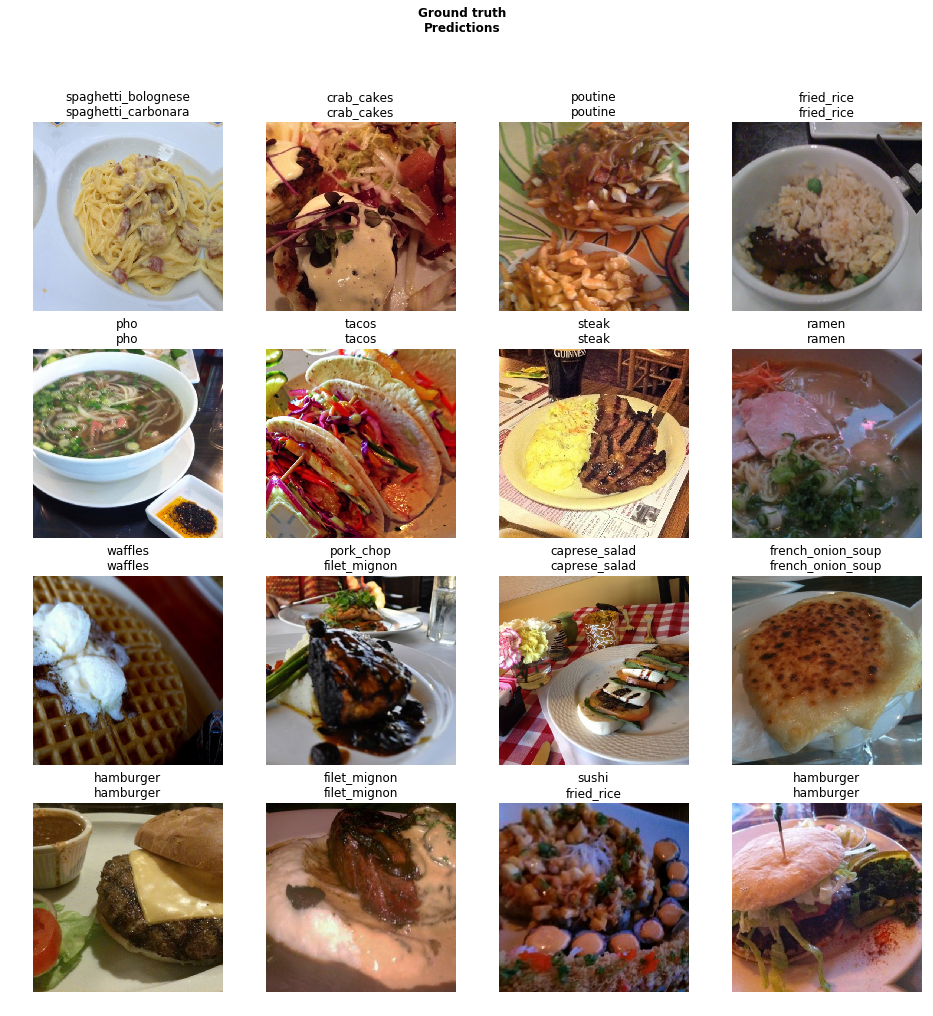

In [22]:
learn.show_results(ds_type=DatasetType.Train) # valid by default

## Interpretation

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

In [15]:
interp.most_confused(min_val=5)

[('steak', 'filet_mignon', 28),
 ('chocolate_mousse', 'chocolate_cake', 24),
 ('filet_mignon', 'steak', 21),
 ('apple_pie', 'bread_pudding', 18),
 ('chocolate_cake', 'chocolate_mousse', 16),
 ('dumplings', 'gyoza', 16),
 ('donuts', 'beignets', 14),
 ('steak', 'prime_rib', 14),
 ('beef_tartare', 'tuna_tartare', 12),
 ('steak', 'pork_chop', 12),
 ('breakfast_burrito', 'huevos_rancheros', 11),
 ('prime_rib', 'steak', 11),
 ('pulled_pork_sandwich', 'hamburger', 11),
 ('scallops', 'foie_gras', 11),
 ('grilled_cheese_sandwich', 'club_sandwich', 10),
 ('ice_cream', 'frozen_yogurt', 10),
 ('pork_chop', 'grilled_salmon', 10),
 ('pork_chop', 'filet_mignon', 9),
 ('pork_chop', 'steak', 9),
 ('spring_rolls', 'samosa', 9),
 ('breakfast_burrito', 'chicken_quesadilla', 8),
 ('chocolate_mousse', 'panna_cotta', 8),
 ('fried_calamari', 'onion_rings', 8),
 ('greek_salad', 'caesar_salad', 8),
 ('macaroni_and_cheese', 'risotto', 8),
 ('panna_cotta', 'chocolate_mousse', 8),
 ('prime_rib', 'filet_mignon', 8)

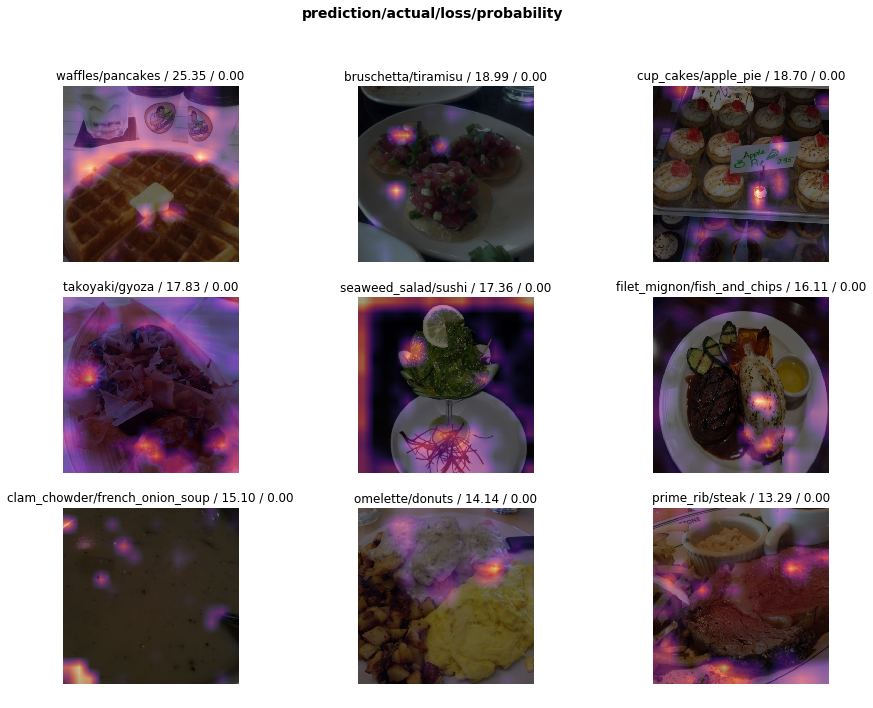

In [16]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=200)

In [ ]:
interp.plot_multi_top_losses()

## Test

In [50]:
bs=16

test_data = (ImageList.from_df(df=test_df, path=path_img, cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

In [51]:
test_learn = cnn_learner(test_data, models.resnet50, metrics=[accuracy, top_5])

In [52]:
test_learn.load('resnet50-stage2-6')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [ ]:
test_data.classes

In [53]:
str(test_learn.metrics)

'[<function accuracy at 0x7fcce7dbf0d0>, functools.partial(<function top_k_accuracy at 0x7fcce7dbf1e0>, k=5)]'

In [54]:
test_learn.validate(test_data.train_dl) # Return the calculated loss and the metrics of the current model

[0.46703085, tensor(0.8688), tensor(0.9753)]

## Predicting for New Images

In [ ]:
# img = learner.data.train_ds[0][0]
# learner.predict(img)

In [55]:
data2 = ImageDataBunch.single_from_classes(path_img, 
                                          learn.data.classes,
                                          ds_tfms=get_transforms(),
                                          size=512).normalize(imagenet_stats)

In [56]:
learn2 = cnn_learner(data2, models.resnet50)

In [57]:
learn2.load('resnet50-stage2-6')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/food-101/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/food-101/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel

In [ ]:
data2.classes, data2.c

In [58]:
# banana - Food Items NOT IN Training Data
url = "https://image.shutterstock.com/image-photo/single-banana-isolated-260nw-575528569.jpg"

# table - Fake
url = "https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg"

# url = "https://img.grouponcdn.com/deal/mJyn1PCrztjcL9q7ao99/Xn-2048x1229/v1/c700x420.jpg"

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Strawberry_ice_cream_cone_%285076899310%29.jpg/220px-Strawberry_ice_cream_cone_%285076899310%29.jpg"

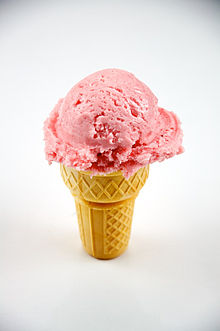

In [59]:
response = requests.get(url)
img = open_image(BytesIO(response.content))
img

In [60]:
pred_class, pred_idx, outputs = learn2.predict(img)

In [61]:
res =  zip (learn2.data.classes, outputs.tolist())
sorted(res, key=lambda x:x[1], reverse=True)

[('ice_cream', 0.8157450556755066),
 ('cup_cakes', 0.1644493043422699),
 ('macarons', 0.008614144288003445),
 ('spaghetti_carbonara', 0.0031277574598789215),
 ('chocolate_mousse', 0.0028261165134608746),
 ('frozen_yogurt', 0.00101028336212039),
 ('chocolate_cake', 0.0008063842542469501),
 ('beef_tartare', 0.0006468789069913328),
 ('apple_pie', 0.0006013546953909099),
 ('waffles', 0.0004986888961866498),
 ('foie_gras', 0.0004299335996620357),
 ('red_velvet_cake', 0.00026068883016705513),
 ('strawberry_shortcake', 0.0001729150244500488),
 ('spaghetti_bolognese', 0.00011044251004932448),
 ('lobster_roll_sandwich', 0.00010700862912926823),
 ('pho', 8.549325139028952e-05),
 ('steak', 6.893595855217427e-05),
 ('cheesecake', 6.439610297093168e-05),
 ('panna_cotta', 5.795768083771691e-05),
 ('filet_mignon', 4.423444624990225e-05),
 ('tuna_tartare', 3.279115480836481e-05),
 ('bread_pudding', 3.1118692277232185e-05),
 ('donuts', 2.885096000682097e-05),
 ('prime_rib', 2.7254389351583086e-05),
 ('

In [62]:
learn2.predict(img)

(Category ice_cream,
 tensor(58),
 tensor([6.0135e-04, 2.4542e-06, 1.0476e-05, 3.1326e-06, 6.4688e-04, 6.1786e-06,
         2.7507e-06, 1.3359e-06, 3.1119e-05, 5.1206e-07, 1.8514e-07, 1.1112e-07,
         3.0835e-06, 1.6410e-08, 2.0408e-06, 3.8503e-06, 1.7937e-06, 6.4396e-05,
         1.0234e-06, 1.3277e-08, 3.4555e-07, 8.0638e-04, 2.8261e-03, 1.3718e-06,
         1.0915e-06, 1.1745e-07, 2.2934e-07, 1.0003e-05, 1.9122e-06, 1.6445e-01,
         2.6095e-06, 2.8851e-05, 8.9092e-06, 2.1385e-08, 2.7983e-06, 2.4109e-07,
         2.0243e-07, 4.4234e-05, 1.6831e-07, 4.2993e-04, 1.6201e-06, 4.2445e-07,
         3.6632e-07, 4.6650e-08, 7.3627e-07, 1.0103e-03, 7.3086e-07, 2.1258e-07,
         1.7770e-08, 5.8824e-08, 6.4922e-07, 5.5911e-07, 2.4073e-08, 1.2747e-06,
         5.0512e-08, 7.5064e-07, 5.9776e-07, 1.1690e-05, 8.1575e-01, 8.6831e-07,
         7.0421e-06, 1.0701e-04, 6.4889e-07, 8.6141e-03, 3.2808e-08, 1.3248e-08,
         1.3426e-07, 2.0543e-07, 3.5945e-07, 1.2761e-07, 3.5453e-06, 2.5965

In [37]:
print(pred_class, pred_idx, outputs, outputs[pred_idx])

ice_cream tensor(58) tensor([5.5095e-04, 2.5519e-06, 3.0298e-05, 3.5651e-06, 5.7667e-04, 5.1096e-06,
        1.9479e-06, 1.2829e-06, 3.9036e-05, 8.1742e-07, 1.3429e-07, 1.1249e-07,
        2.4844e-06, 4.5110e-08, 3.2947e-06, 2.8721e-06, 9.9504e-07, 1.0939e-04,
        7.3122e-07, 6.5901e-09, 2.1710e-07, 1.1355e-03, 4.0619e-03, 5.2558e-07,
        6.7089e-07, 9.1882e-08, 5.9376e-07, 2.7392e-05, 3.2885e-06, 3.6792e-01,
        5.0082e-06, 4.7613e-05, 4.4314e-06, 2.3939e-08, 6.2033e-06, 6.4197e-07,
        1.9612e-07, 7.0356e-05, 2.4810e-07, 2.8966e-04, 1.3944e-06, 1.1654e-06,
        2.3435e-07, 3.7919e-08, 7.8766e-07, 4.9821e-04, 7.2355e-07, 2.8853e-07,
        1.7192e-08, 1.2292e-07, 1.2857e-06, 2.5392e-07, 8.4247e-09, 4.7851e-06,
        1.0846e-07, 2.2799e-06, 7.9928e-07, 3.6843e-06, 5.9273e-01, 1.4313e-06,
        9.6487e-06, 7.2536e-05, 1.1188e-06, 2.6974e-02, 2.7638e-08, 1.0079e-08,
        3.8137e-08, 4.6675e-07, 9.2704e-07, 9.2881e-08, 2.4817e-06, 5.0203e-07,
        5.1408e-06,

## Analysis

State of the Art results: 90.27% from WISeR.

Our results: 82.69%

`Possible improvements:`
- Transformations + Augmentation (esp. TTA, e.g. jitter, skew, brightness, contrast)
- Deeper ResNet Model
- More training/epoch

## Save final model

In [ ]:
final_model_name = ' '

## Export

In [65]:
learn.export()